In [1]:
%matplotlib inline
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from poison_evaluation.models import ResNet18
from tqdm import tqdm
import torchvision.transforms.functional as F

In [2]:
cifar_path = '/vulcanscratch/psando/cifar-10'
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

testset = torchvision.datasets.CIFAR10(
        root=cifar_path, train=True, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

In [3]:
import village 
cifar_ckpt_path = '/vulcanscratch/psando/cifar_model_ckpts'
model_name = 'ResNet18'
cifar_ckpt = os.path.join(cifar_ckpt_path, model_name + '.pt')
ckpt = torch.load(cifar_ckpt)

model = village.clients.models.resnet_picker('ResNet18', 'CIFAR10')
model.load_state_dict(ckpt['model'])
model = model.cuda()
model.eval()
pass

In [4]:
# Save representation layer features

# features = []
# def log_feature(module, input, output):
#     batch_size = output.size(0)
#     features.append(output.reshape(batch_size, -1))
#     return None

# handle = model.avgpool.register_forward_hook(log_feature)

# with torch.no_grad():
#     for x, y in tqdm(testloader):
#         x, y = x.cuda(), y.cuda()
#         o = model(x)
        
# handle.remove()

# features = torch.cat(features, dim=0) # shape (50000, 512)
# print(features.shape)
# torch.save(features, 'trainset_features.pt')

# Load features
features = torch.load('trainset_features.pt') # shape (50000, 512)

In [5]:
num_principal_dirs = 2
pca_iters = 100

C = features.mean(dim=(-2,), keepdim=True)
features = features - C
usv = torch.pca_lowrank(features, q=num_principal_dirs, center=False, niter=pca_iters)

In [6]:
# Check covariance of num_principal_dirs 
S = usv[1]
cov = S ** 2 / (features.size(0) - 1)
print(cov) # [4.6434, 3.4170]

tensor([4.6434, 3.4170], device='cuda:0')


In [7]:
# Project onto first two principal components
V = usv[2] # shape (512, 6)
proj_features = torch.matmul(features, V[:, :num_principal_dirs]) # shape (50000, 2)

In [8]:
# Rotate every projected feature
import math
a = math.pi / 4
rot = torch.tensor([[math.cos(a), -math.sin(a)], [math.sin(a), math.cos(a)]]).cuda()
rot_proj_features = torch.matmul(proj_features, rot) # shape (50000, 2)

In [9]:
# Sanity check: dot product between normalized vectors should equal cosine of rotation angle
u = proj_features[0] / torch.norm(proj_features[0], p=2)
v = rot_proj_features[0] / torch.norm(rot_proj_features[0], p=2)
print(torch.dot(u, v))
print(math.cos(a))

tensor(-1., device='cuda:0')
-1.0


In [10]:
# Unproject back rotated features by adding back non-principal components
rot_proj_features = torch.matmul(rot_proj_features, V[:, :num_principal_dirs].T) # shape (50000, 512)
rot_features = rot_proj_features + (features - torch.matmul(proj_features, V[:, :num_principal_dirs].T)) # shape (50000, 512)

# Add back centering translation C
rot_features = rot_features + C

In [11]:
img, label = iter(testloader).next()
img, label = img.cuda(), label.cuda()

In [12]:
from torchvision.models.feature_extraction import create_feature_extractor
feat_model = create_feature_extractor(model, return_nodes=['flatten'])
with torch.no_grad():
    out = feat_model(img)['flatten']
print(out.shape)

torch.Size([100, 512])


In [13]:
# Feature Space Rotation Attack
# Use PGD to optimize perturbation

eps = (8. / 255)
ds = torch.tensor([0.2023, 0.1994, 0.2010])[None, :, None, None].cuda()
dm = torch.tensor([0.4914, 0.4822, 0.4465])[None, :, None, None].cuda()


delta = torch.randn(img.shape, device=img.device)
delta = delta * eps / ds
delta = torch.max(torch.min(delta, eps / ds), -eps / ds)
delta.requires_grad = True


num_steps = 1000
step_size = (eps / num_steps) * 2.5
for i in range(num_steps):
    adv_img = img + delta
    out = feat_model(adv_img)['flatten']
    # minimize the L2 distance between the clean rotated features
    # and the adversarial image's features
    loss = torch.pow(torch.norm((rot_features[:100] - out), p=2), 2)
    if i % 100 == 0:
        print(f'step {i}, loss: {loss.item()}')
    grad_delta = torch.autograd.grad(loss, delta)[0]
    # step in direction of signed gradient
    delta.data = delta.data - grad_delta.sign() * step_size / ds
    # clip to stay within bounds
    delta.data = torch.max(torch.min(delta.data, eps / ds), -eps / ds)
    

step 0, loss: 3025.72216796875
step 100, loss: 1358.7659912109375
step 200, loss: 700.0967407226562
step 300, loss: 486.1727600097656
step 400, loss: 403.1742248535156
step 500, loss: 364.7890319824219
step 600, loss: 345.5522155761719
step 700, loss: 334.26422119140625
step 800, loss: 327.0706481933594
step 900, loss: 322.6011657714844


In [14]:
# Check norm of delta perturbation
# Unnormalize clean and adversarial images and ensure delta is within bound
torch.norm((torch.clip((img * ds + dm),0,1) - torch.clip(((img + delta) * ds + dm),0,1)), p=torch.inf)

tensor(0.0314, device='cuda:0', grad_fn=<NormBackward1>)

In [15]:
with torch.no_grad():
    pred = torch.argmax(model(img), dim=1)
    acc = (pred == label).sum().item() / img.size(0)
    print(f'Accuracy on clean images: {acc * 100:0.2f} %')

Accuracy on clean images: 99.00 %


In [16]:
with torch.no_grad():
    adv_imgs = (img + delta)
    pred = torch.argmax(model(adv_imgs), dim=1)
    acc = (pred == label).sum().item() / adv_imgs.size(0)
    print(f'Accuracy on adv images: {acc * 100:0.2f} %')

Accuracy on adv images: 42.00 %


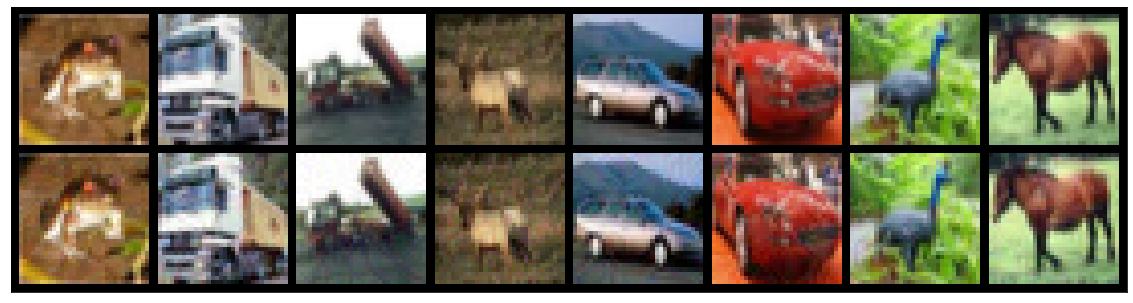

In [17]:
# Display clean and adversarial images
plot_img = torch.clip((img * ds + dm),0,1).detach().cpu()
plot_adv_img = torch.clip(((img + delta) * ds + dm),0,1).detach().cpu()

all_plot = torch.cat([plot_img[:8], plot_adv_img[:8]], dim=0)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20,20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
show(torchvision.utils.make_grid(all_plot, nrow=8))